In [1]:
import sys
sys.path.append('../..')

In [2]:
import os
import importlib
import pickle

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

from sklearn.metrics import cohen_kappa_score

from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

from lib.datasets import get_train_test_img_ids_split, max_lbl_nums, patches_clean90_pkl_path
from lib.dataloaders import WSIPatchesDummyDataloader
from lib.utils import get_pretrained_model
from lib.kappacoefs import OptimizedRounder

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [40]:
# experiments_path = '../../experiments_results/'
experiments_path = '/mnt/HDDData/notebooks/pcancer/experiments_results/'
exp_subfolder = 'wsi_on_dummy_64x8x8'
# bad_qwk_wsi_on_dummy_512x1x1/

# train_batch_path = '/mnt/SSDData/pdata/processed/pretrained/train/{}/'
# test_batch_path = '/mnt/SSDData/pdata/processed/pretrained/val/'
train_batch_path = '/mnt/HDDData/pdata/processed/pretrained_64x8x8/train/{}/'
test_batch_path = '/mnt/HDDData/pdata/processed/pretrained_64x8x8/val/'

In [17]:
val_targets = []
val_outputs_reg = []
val_outputs_class = []

In [41]:
# Bad WSI
experiments = [
    '90ep_adam_exp_with_min_v1/version_0', '90ep_adam_exp_with_min_v2/version_0',
    '90ep_adam_exp_v1/version_0', '90ep_adam_cos_v1/version_0', 
    '90ep_adam_cos_an_v2/version_0', '90ep_adam_cos_an_v1/version_0',
    # '90ep_sgd_cos_v1/version_0', '90ep_sgd_exp_v1/version_0',
    '180ep_adam_exp_v1/version_0', '180ep_adam_exp_v2/version_0',
    '450ep_adam_cos_an_v1/version_0'
]

In [42]:
experiments = [
'90ep_adam_cos_an_v1/version_0',
'90ep_adam_exp_with_min_v1/version_0',
'90ep_adam_exp_v1/version_0',
'90ep_adam_cos_v1/version_0',
'300ep_adam_cos_an_lr150/version_0',
'300ep_adam_cos_an_lr125/version_0',
'300ep_adam_cos_an_lr080/version_0',
'300ep_adam_cos_an_lr100/version_0',]

In [ ]:
experiments = [f"{e.split('.')[0]}/version_0" 
               for e in os.listdir(f"../../experiments_configs/{exp_subfolder}")
              #if not e.startswith('_') and e.find('do') == -1]
               if (e.startswith('90') or 
                   e.startswith('300') or
                   e.startswith('180') or
                  e.startswith('450')) and 
               e.find('batch') == -1 and 
               # e.find('resnext') == -1 and
               e.find('do') == -1]

In [9]:
experiments

['90ep_adam_exp_with_min_v1/version_0',
 '90ep_adam_exp_v1_grad_acc4/version_0',
 '90ep_adam_exp_v1/version_0',
 '90ep_adam_cos_v1/version_0',
 '90ep_adam_cos_an_v1/version_0']

In [10]:
with open(patches_clean90_pkl_path, 'rb') as f:
    wsi_dict = pickle.load(f)

In [11]:
yxs_to_image_id = {}
for image_id, rows in wsi_dict.items():
    ys = []
    xs = []
    for row in rows:
        (_, image_id, data_provider, isup_grade, gleason_score, y, x, *_) = row
        ys.append(str(y))
        xs.append(str(x))
        
    key = (','.join(ys[:300])) + ' ' + (','.join(xs[:300]))
    
    yxs_to_image_id[key] = image_id

In [12]:
len(yxs_to_image_id)

10515

In [13]:
device = torch.device('cuda:1')

In [18]:
for experiment_path in tqdm(experiments):
    #try:
    exp_name = experiment_path.split('/')[0]

    echeckpoint_path = os.path.join(experiments_path, exp_subfolder, 
                                    experiment_path, 'checkpoints', 'last.ckpt')

    
    e_mod = importlib.import_module(f'experiments_configs.{exp_subfolder}.{exp_name}')
    hparams = e_mod.get_hrapams()

    model_cfg = hparams['module']['params']['model']

    model = get_pretrained_model(model_cfg['name'], model_cfg['params'], 
                                 echeckpoint_path, device, False)

    val_loader = WSIPatchesDummyDataloader(test_batch_path,
                                           precalc_epochs=hparams['dataset']['precalc_epochs'],
                                           shuffle=False)    

    if hasattr(e_mod, 'd'):
        importlib.reload(e_mod.d)
    
    model.eval()

    targets = []
    outputs_reg = []
    outputs_class = []

    with torch.no_grad():
        for features, ys, xs, provider, target, gleason_score in val_loader:
            b = features.shape[0]

            features, target = features.to(device), target.to(device)
            target = target.float()

            output_reg, output_class = model(features, ys, xs)
            output_reg = torch.sigmoid(output_reg) * max_lbl_nums - 0.5
            output_class = F.softmax(output_class, dim=-1)

            targets.append(target)
            outputs_reg.append(output_reg)
            outputs_class.append(output_class)            

    del model        

    val_targets.append(torch.cat(targets).cpu().numpy())
    val_outputs_reg.append(torch.cat(outputs_reg).cpu().numpy())
    val_outputs_class.append(torch.cat(outputs_class).cpu().numpy()) 
    #except:
    #    print(f"Error {experiment_path}")

In [19]:
np_val_targets = np.stack(val_targets)
np_val_outputs_reg = np.stack(val_outputs_reg)[..., 0]
np_val_outputs_class = np.stack(val_outputs_class)

In [20]:
providers = []
yss = []
xss = []
for features, ys, xs, provider, target, gleason_score in val_loader:
    providers.append(provider)
    yss.append(ys)
    xss.append(xs)
    
providers = torch.cat(providers).cpu().numpy()
yss = torch.cat(yss).cpu().numpy()
xss = torch.cat(xss).cpu().numpy()

In [21]:
val_image_ids = []
for n in range(len(yss)):
    key = ((','.join([str(c) for c in yss[n][yss[n] != -1].tolist()])) + ' ' + 
           (','.join([str(c) for c in xss[n][xss[n] != -1].tolist()])))
    
    val_image_ids.append(yxs_to_image_id[key])

In [22]:
val_image_ids[:4]

['375b2c9501320b35ceb638a3274812aa',
 'e4e49a91640feea58d109aff11df4197',
 '5b003d43ec0ce5979062442486f84cf7',
 '9b2948ff81b64677a1a152a1532c1a50']

In [23]:
import pandas as pd

In [24]:
susp_image_ids_df = pd.read_csv('/mnt/SSDData/pdata/processed/PANDA_Suspicious_Slides.csv')

In [25]:
susp_val = np.isin(val_image_ids, susp_image_ids_df[susp_image_ids_df['reason'] != 'marks']['image_id'].values)

In [26]:
susp_val.sum()

18

In [27]:
p = 1
for val_output_reg, val_output_class, val_target in zip(np_val_outputs_reg, np_val_outputs_class, np_val_targets):
    idxs = (providers==p) & ~susp_val
    val_output_reg = np.clip(val_output_reg.round(), -0.5, 5.5)[idxs]
    val_output_class = val_output_class.argmax(-1)[idxs]
    val_target = val_target[idxs]
    
    #arr = np.arange((val_output_class != val_target).sum())
    #np.random.shuffle(arr)
    
    # val_output_class[arr[:520]] = val_target[arr[:520]]
    #w_idxs = val_output_class != val_target
    #w_idxs[690:] = False
    #val_output_reg[w_idxs] = val_target[w_idxs]
    #val_output_class[w_idxs] = val_target[w_idxs]
    
    qwk_reg = cohen_kappa_score(val_output_reg, val_target, weights="quadratic")
    acc_reg = (val_output_reg == val_target).mean()
    
    qwk_class = cohen_kappa_score(val_output_class, val_target, weights="quadratic")
    acc_class = (val_output_class == val_target).mean()    
    print(qwk_reg, acc_reg, qwk_class, acc_class)

0.8673845038721245 0.7277777777777777 0.8458332791901297 0.7361111111111112
0.8645448276191583 0.7212962962962963 0.8416272785521269 0.7333333333333333
0.8618703522489298 0.7111111111111111 0.8356219703030423 0.7324074074074074
0.8628852689558186 0.7287037037037037 0.8452008676296018 0.7453703703703703
0.8671560943053593 0.7166666666666667 0.8464714365029977 0.7425925925925926


In [28]:
# w_idxs.sum()

In [29]:
lbl = 0

In [30]:
for val_output_reg, val_output_class, val_target in zip(np_val_outputs_reg, np_val_outputs_class, np_val_targets):
    idxs = np.ones(val_target.shape[0], dtype=np.bool) & ~susp_val
    val_output_reg = np.clip(val_output_reg.round(), -0.5, 5.5)[idxs]
    val_output_class = val_output_class.argmax(-1)[idxs]
    val_target  = val_target[idxs]
    
    qwk_reg = cohen_kappa_score(val_output_reg, val_target, weights="quadratic")
    acc_reg = (val_output_reg == val_target).mean()
    
    qwk_class = cohen_kappa_score(val_output_class, val_target, weights="quadratic")
    acc_class = (val_output_class == val_target).mean()    
    print(qwk_reg, acc_reg, qwk_class, acc_class)

0.869476782184122 0.62782859894078 0.8595608050482554 0.6961964371689937
0.8710326919200819 0.6268656716417911 0.8542694874996598 0.6812710640346654
0.8681516768267711 0.6283100625902744 0.8496224104284746 0.6894559460760713
0.8674885530003604 0.6364949446316803 0.8525049867435881 0.6981222917669716
0.8785356601984006 0.6422725084256139 0.8633280840837068 0.698603755416466


In [31]:
lbl = 0

In [32]:
((val_output_class == lbl) == (val_target == lbl)).mean()

0.9552238805970149

In [33]:
((val_output_reg == lbl) == (val_target == lbl)).mean()

0.9364467982667308

In [34]:
p = 1
idxs = (providers==p) & ~susp_val
val_target = np_val_targets[0]
val_output = np_val_outputs_reg[:].mean(axis=0)
val_output_raw = val_output.copy()
val_output = np.clip(val_output.round(), -0.5, 5.5)
qwk_reg = cohen_kappa_score(val_target[idxs], val_output[idxs], weights="quadratic")

In [35]:
qwk_reg

0.870819968146083

In [36]:
val_target = np_val_targets[0]
val_output = np_val_outputs_reg[:].mean(axis=0)
val_output_raw = val_output.copy()
val_output = np.clip(val_output.round(), -0.5, 5.5)
qwk_reg = cohen_kappa_score(val_target, val_output, weights="quadratic")

In [37]:
qwk_reg

0.8645876502695777

In [38]:
val_target = np_val_targets[0]
val_output = np_val_outputs_reg[:].mean(axis=0)
val_output_raw = val_output.copy()
val_output = np.clip(val_output.round(), -0.5, 5.5)
qwk_reg = cohen_kappa_score(val_target[~susp_val], val_output[~susp_val], weights="quadratic")

In [39]:
qwk_reg

0.8764893263208833

In [76]:
optimized_rounder = OptimizedRounder()

In [77]:
optimized_rounder.fit(val_output_raw[~susp_val], val_target[~susp_val])

In [78]:
# 0 - array([0.57281728, 1.50037176, 2.38909082, 3.42044636, 4.17974069])
# 1 - array([0.52981011, 1.44531919, 2.38075203, 3.56832626, 4.45295682])
optimized_rounder.coefficients()

array([0.50939092, 1.65725755, 2.35192337, 3.35145924, 4.17272064])

In [85]:
val_output2 = optimized_rounder.predict(val_output_raw, old_coefs)
# val_output2 = optimized_rounder.predict(val_output_raw, optimized_rounder.coefficients())

In [86]:
cohen_kappa_score(val_target[~susp_val], val_output2[~susp_val], weights="quadratic")

0.8964139099949694

In [482]:
# !!! Это максимум !!! На валидации обучался !!!
cohen_kappa_score(val_target[providers==p], val_output2[providers==p], weights="quadratic")

0.876489613405978

In [486]:
val_output01 = val_output2.copy()

In [487]:
p = 0
val_output01[providers==p] = optimized_rounder.predict(val_output_raw[providers==p], 
                                                      np.array([0.57281728, 1.50037176, 2.38909082, 3.42044636, 4.17974069]))
p = 1
val_output01[providers==p] = optimized_rounder.predict(val_output_raw[providers==p], 
                                                      np.array([0.52981011, 1.44531919, 2.38075203, 3.56832626, 4.45295682]))

In [488]:
cohen_kappa_score(val_target, val_output01, weights="quadratic")

0.8851264287913517

In [443]:
# !!! Это на старых !!!
cohen_kappa_score(val_target, val_output2, weights="quadratic")

0.8798580508889466

0.884086056976147

In [83]:
old_coefs =\
np.array(
[[0.54569598, 1.62824866, 2.35215448, 3.27274745, 4.14168655],
 [0.55146103, 1.54651653, 2.41228703, 3.2341663,  4.18983145],
 [0.52759456, 1.66193384, 2.42119538, 3.22981731, 4.1679057 ],
 [0.50560013, 1.66279228, 2.48869419, 3.20977081, 4.21148184],
 [0.59420817, 1.58363668, 2.40486243, 3.21171697, 4.22344555],
 [0.55964892, 1.58687257, 2.42119557, 3.20594279, 4.20727218],
 [0.52965801, 1.62990205, 2.56598612, 3.18684522, 4.0254026 ],
 [0.56310764, 1.63544987, 2.44483939, 3.12796843, 4.08308392],
 [0.54240544, 1.61370524, 2.52179569, 3.2963418,  4.09494376], 
 [0.55924867, 1.64874465, 2.49730719, 3.25221745, 4.15355419]]).mean(axis=0)

In [84]:
old_coefs

array([0.54786285, 1.61978024, 2.45303175, 3.22275345, 4.14986077])

In [261]:
# val_output[((val_output == 0) & (val_target > 1))] = 4
# val_output[((val_output == 5) & (val_target < 5))] = 4

In [639]:
strange_idx = ((val_output == 0) & (val_target > 1))

In [759]:
strange_idx.sum()

18

In [774]:
np.array(val_image_ids)[strange_idx & susp_val]

array(['158754df49e00760f8e4659a05e7cc0c',
       '7e7e6dac3271a6cad2744ae393328a36',
       '8d9e28e97edc6598da7df0b5b7c098d6',
       '2ce127e7731155d1373bfbd0abdc368b',
       '44f60ac5d5d82e5c72d077e50701863d'], dtype='<U32')

In [775]:
np.array(val_image_ids)[strange_idx & ~susp_val]

array(['ec382d53fa1973de25c35af7af550aff',
       '07a7ef0ba3bb0d6564a73f4f3e1c2293',
       'e919022fbfe7c9ff599a866aa0be352f',
       'f187290ba0d588d11f47467ec93ce202',
       'f19fe3c267aa523b6b96393d698ab273',
       '979eda484717cd406350e95df7862329',
       '2464608febcd797682b2392b5badbc2d',
       'dc60380b0dba9d1876e40f0b53ec484b',
       '741f6260e0f75b64a72e9a905003c29d',
       '7f50cd92c0f5cca94434fc6165354acd',
       '9aea86aa9b34cebb8bbc0db42d6c7559',
       'af2e93677f85a4ff065cfd55c279793d',
       '0bd0a172d1f92a1c8bb43585affe0648'], dtype='<U32')

In [ ]:
val_output_raw[strange_idx & ~susp_val]

In [757]:
# val_target[strange_idx]

In [756]:
# np.clip(np_val_outputs[:, strange_idx].round(), -0.5, 5.5)

In [247]:
th = 1.0
dif_idx_mask = dif_idx > th

In [248]:
dif_idx_mask.sum()

18

In [249]:
(val_output[dif_idx_mask] == val_target[dif_idx_mask]).mean()

0.05555555555555555

In [ ]:
cohen_kappa_score(val_target[dif_idx_mask], val_output[dif_idx_mask], weights="quadratic")

In [255]:
val_output[dif_idx_mask] = val_target[dif_idx_mask]

In [37]:
qwk_reg = cohen_kappa_score(val_target, val_output, weights="quadratic")

In [38]:
qwk_reg

0.8812285676128291

In [89]:
cm = confusion_matrix(val_target, val_output)
cmd = ConfusionMatrixDisplay(cm, display_labels=[f'grade{n}' for n in range(max_lbl_nums)])

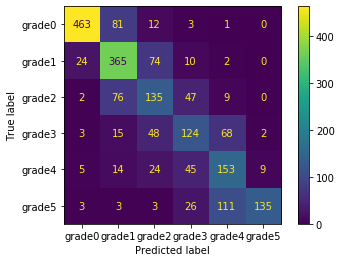

In [90]:
cmd.plot(values_format='d');

In [87]:
cm = confusion_matrix(val_target[~susp_val], val_output[~susp_val])
cmd = ConfusionMatrixDisplay(cm, display_labels=[f'grade{n}' for n in range(max_lbl_nums)])

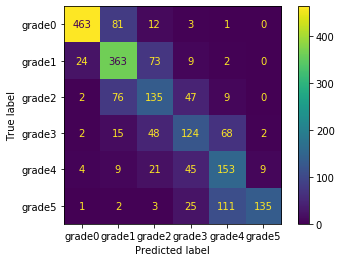

In [88]:
cmd.plot(values_format='d');

In [91]:
cm = confusion_matrix(val_target, val_output2)
cmd = ConfusionMatrixDisplay(cm, display_labels=[f'grade{n}' for n in range(max_lbl_nums)])

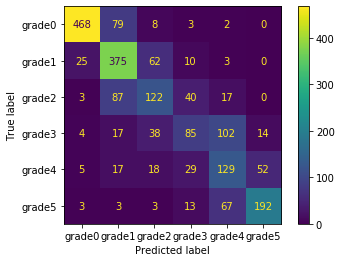

In [92]:
cmd.plot(values_format='d');

In [93]:
cm = confusion_matrix(val_target[~susp_val], val_output2[~susp_val])
cmd = ConfusionMatrixDisplay(cm, display_labels=[f'grade{n}' for n in range(max_lbl_nums)])

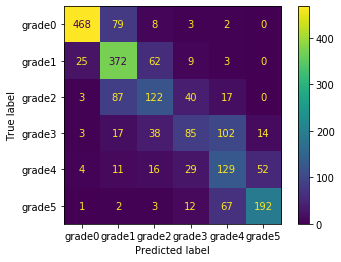

In [94]:
cmd.plot(values_format='d');

In [96]:
tmp = np_val_outputs_reg

In [97]:
tmp.shape

(31, 2095)

In [98]:
dif_idx = np.abs((tmp[:, None, :] - tmp[None, :, :])).mean(axis=(0,1))

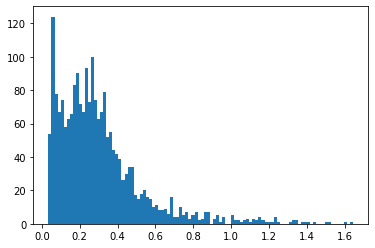

In [99]:
plt.hist(dif_idx, bins=100);

In [57]:
mean_qwk_regs = []
real_qwk_regs = []

for n in range(len(np_val_outputs)):
    val_output, val_target = np_val_outputs[n], np_val_targets[n]
    val_output = np.clip(val_output.round(), -0.5, 5.5)

    real_qwk_regs.append(cohen_kappa_score(val_output, val_target, weights="quadratic"))

    qwk_regs = []
    for b in range(0, len(val_output), 64):
        qwk_reg = cohen_kappa_score(val_output[b:b+64], val_target[b:b+64], weights="quadratic")
        qwk_regs.append(qwk_reg)
        # print(qwk_reg)

    mean_qwk_regs.append(sum(qwk_regs) / len(qwk_regs))

In [58]:
mean_qwk_regs[0]

0.8478560161334803

In [59]:
real_qwk_regs[0]

0.853761742673917

In [184]:
np.array(real_qwk_regs) - np.array(mean_qwk_regs)

array([0.00590573, 0.00475616, 0.00505762, 0.00529246, 0.00454274,
       0.00441364, 0.00510879, 0.00577147, 0.00335479])

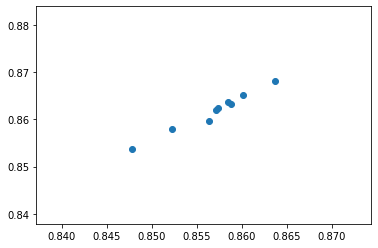

In [60]:
plt.scatter(mean_qwk_regs, real_qwk_regs)

In [33]:
model.eval()

targets = []
o_outputs = []
outputs = []

with torch.no_grad():
    for features, ys, xs, provider, target, gleason_score in val_loader:
        b = features.shape[0]

        features, target = features.to(device), target.to(device)
        target = target[:, None].float()

        output, o_labels_class = model(features, ys, xs)
        output = torch.sigmoid(output) * max_lbl_nums - 0.5
        o_output = output.round().long().clamp(-0.5, 5.5)

        targets.append(target)
        o_outputs.append(o_output)
        outputs.append(output)

val_o_outputs = torch.cat(o_outputs).cpu().numpy()
val_targets = torch.cat(targets).cpu().numpy()
val_outputs = torch.cat(outputs).cpu().numpy()

all_coefficients = []

for epoch in range(10):
    targets = []
    o_outputs = []
    outputs = []

    with torch.no_grad():
        for features, ys, xs, provider, target, gleason_score in train_loader:
            b = features.shape[0]

            features, target = features.to(evice), target.to(device)
            target = target[:, None].float()

            output, o_labels_class = model(features, ys, xs)
            output = torch.sigmoid(output) * max_lbl_nums - 0.5
            o_output = output.round().long().clamp(-0.5, 5.5)

            targets.append(target)
            o_outputs.append(o_output)
            outputs.append(output)

    o_outputs = torch.cat(o_outputs).cpu().numpy()
    targets = torch.cat(targets).cpu().numpy()
    outputs = torch.cat(outputs).cpu().numpy()

    optimized_rounder = OptimizedRounder()
    optimized_rounder.fit(outputs, targets)
    coefficients = optimized_rounder.coefficients()
    print(coefficients)
    all_coefficients.append(coefficients)

NameError: name 'WSIPatchesDummyDataset' is not defined